# The Gaspari-Cohn function and covariance localization

* Emmanuel Cosme, 2017
* Illustrates the Gaspari-Cohn function and covariance localization for EnKF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## 1. Definition of the Gaspari-Cohn function

In [2]:
def gaspari_cohn(r):
    """Gaspari-Cohn function."""
    if type(r) is float:
        ra = np.array([r])
    else:
        ra = r
    ra = np.abs(ra)
    gp = np.zeros_like(ra)
    i=np.where(ra<=1.)[0]
    gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
    i=np.where((ra>1.)*(ra<=2.))[0]
    gp[i]=1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
    if type(r) is float:
        gp = gp[0]
    return gp

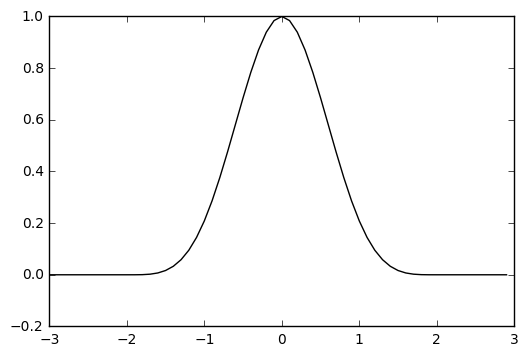

In [3]:
x = np.arange(-3., 3., 0.1)  # z/c
plt.plot(x, gaspari_cohn(x),'k')

The GC function looks like a Gaussian function, but the support is compact. Function values are real zeros beyond $x=2$.

## 2. Why localization? Illustration

We consider a 1-dimensional, periodic domain with 40 grid points regularly spaced. Some PDE involving only 1 variable is solved over this domain (this is the basic Lorenz-95 system setup). The state vector contains 40 entries. The covariance matrix is $40 \times 40$.

To illustrate the sub-sampling issue that motivates localization, we proceed as follows:
- We create a "true" covariance matrix ${\bf P_t}$ analytically (the way it is done here is not important. It is actually an exponential correlation function);
- we create an ensemble by sampling a Gaussian density with mean 0 and covariance matrix ${\bf P_t}$;
- we compute the ensemble covariance matrice ${\bf P_e}$ and compare it with ${\bf P_t}$.

### Grid definition

In [4]:
n_grid = 40                          # number of grid points
d_grid = 1.                          # grid point spacing
L_grid = n_grid * d_grid             # Domain length
x_grid = d_grid * np.arange(n_grid)  # grid point location

### Create true covariance matrix

In [5]:
dcut = 4.                            # Correlation length scale
variance = 4.
Pt = np.zeros((n_grid, n_grid))
for j in range(n_grid):
    for i in range(n_grid):
        rad = np.abs(x_grid[i]-x_grid[j])
        rad = np.min((rad,L_grid-rad))        # Periodic domain
        Pt[i,j] = variance * np.exp(-rad/dcut)

### Create ensemble

In [6]:
n_ens = 50                            # ensemble size
ens_mean = np.zeros(n_grid)           # ensemble mean
Xens = np.random.multivariate_normal(ens_mean, Pt, n_ens)       # Create ensemble
print np.shape(Xens)

(50, 40)


### Compute ensemble covariance matrix
We compute the ensemble mean, ensemble anomaly matrix, then the ensemble covariance matrix.

In [7]:
Xmean = np.mean(Xens, axis = 0)
Xanom = np.empty_like(Xens)
for ie in range(n_ens):
    Xanom[ie,:] = ( Xens[ie,:] - Xmean ) / np.sqrt(n_ens-1)
Pe = np.dot(Xanom.T, Xanom)

### Comparison of the two matrices
We plot below ${\bf P_t}$ and ${\bf P_e}$.

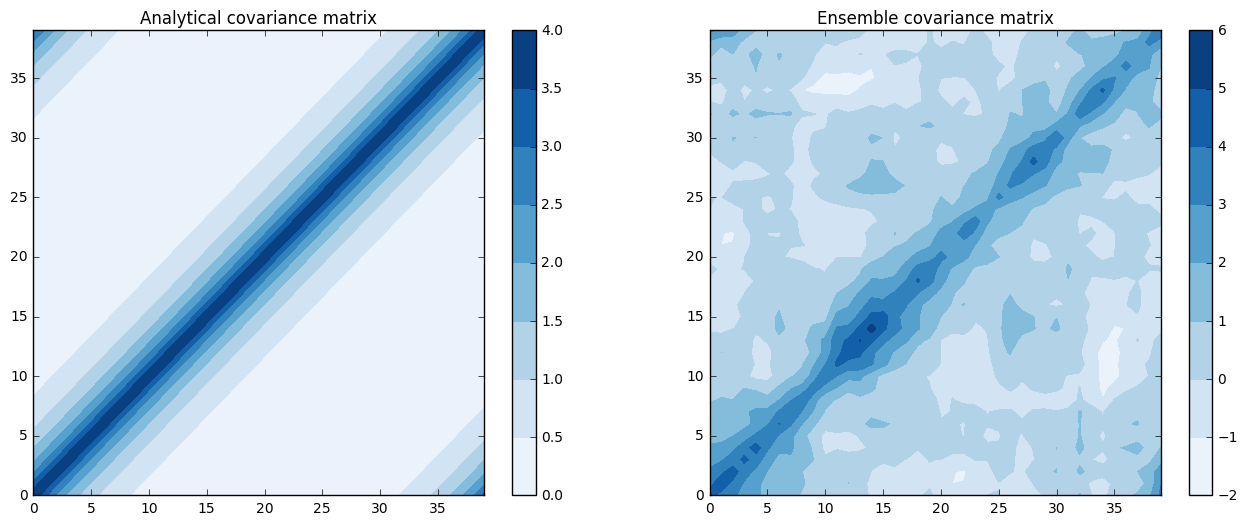

In [8]:
X,Y = np.meshgrid(x_grid, x_grid)

fig = plt.figure(figsize=(16,6))
#fig.suptitle("Title for whole figure", fontsize=16)
ax = plt.subplot(1,2,1)
im = ax.contourf(X, Y, Pt, cmap = cm.Blues)
ax.set_title('Analytical covariance matrix')
fig.colorbar(im)

ax = plt.subplot(1,2,2)
im = ax.contourf(X, Y, Pe, cmap = cm.Blues)
ax.set_title('Ensemble covariance matrix')
fig.colorbar(im)


### Conclusion
We recognize in ${\bf P_e}$ the general shape from ${\bf P_t}$, but the ensemble matrix is very noisy compared to the original. On the diagonal, the orders of magnitude are correct (entries reaching the colobar max are sparse...). The covariance localization technique is designed to rule out entries far from the diagonal, assuming they should be zeros (which is the case here, according to ${\bf P_t}$).

## 3. Covariance localization

Here, we create a localization matrix $\rho$ using the Gaspari-Cohn function, and compute the Schur (Hadamard) product with the ensemble covariance matrix ${\bf P_e}$.

### Localization matrix

In [9]:
crad = 6.    # cutoff radius

rho = np.zeros((n_grid, n_grid))
for j in range(n_grid):
    for i in range(n_grid):
        rad = np.abs(x_grid[i]-x_grid[j])
        rad = np.min((rad,L_grid-rad))          # For a periodic domain, again
        rad = np.array([rad/crad])
        rho[i,j] = gaspari_cohn(rad)

### Localized ensemble covariance matrix and plots

In [10]:
Pe_loc = rho * Pe

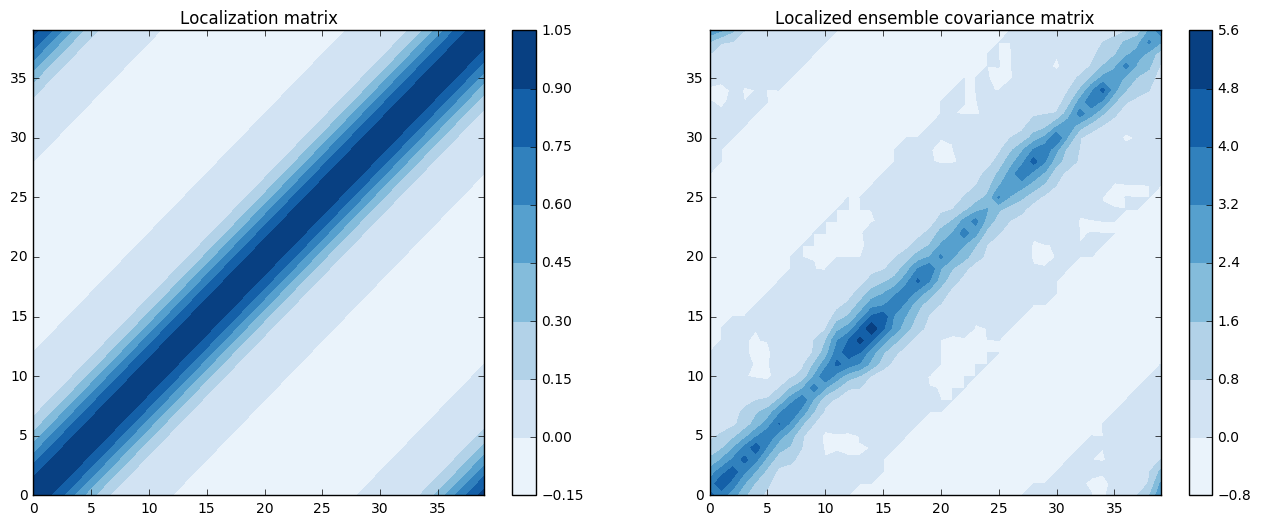

In [11]:
fig = plt.figure(figsize=(16,6))
#fig.suptitle("Title for whole figure", fontsize=16)
ax = plt.subplot(1,2,1)
im = ax.contourf(X, Y, rho, cmap = cm.Blues)
ax.set_title('Localization matrix')
fig.colorbar(im)

ax = plt.subplot(1,2,2)
im = ax.contourf(X, Y, Pe_loc, cmap = cm.Blues)
ax.set_title('Localized ensemble covariance matrix')
fig.colorbar(im)

We note that in the localization matrix, entries far from the diagonal, where distances between grid points are between 10 and 20 (20 is the maximum, considering the domain is periodic), are zeros. So are entries in the localized ensemble covariance matrix. With the covariance localization technique, this filtered covariance matrix is used to compute the gain.

## 4. Computing the Kalman gain with covariance localization

For simplicity we consider here the case of a single observation. With a single observation, ${\bf H}{\bf P_e}{\bf H}^T$ is a scalar (ensemble variance of the observed variable) and does not require $\rho$-localization. With multiple observations, the two options are (i) serial processing of observations and (ii) tapering of ${\bf H}{\bf P_e}{\bf H}^T$. This is not addressed in this notebook.

Below we first define an operator observing grid point $nobs=15$.
Then we compute ${\bf P_t}{\bf H}^T$ and ${\bf P_e}{\bf H}^T$.

In [12]:
Hobs = np.zeros(n_grid)
nobs = 15
Hobs[nobs] = 1.
#Hobs[nobs:nobs+4]=np.array(4*[0.25])
PtHobsT = np.inner(Pt,np.transpose(Hobs))
PeHobsT = np.inner(Pe,np.transpose(Hobs))

From now on, we have two options:

1. Follow the strict application of localization, and compute $ (\rho \circ {\bf P_e}){\bf H}^T$. However, since in practice $\rho \circ {\bf P_e}$ is not calculated, we replace the previous calculation of $ (\rho \circ {\bf P_e}){\bf H}^T$ by option 2:
2. the tapering function approach of Sakov et Bertino (2010), where a tapering function is designed from the Gaspari-Cohn function and applied to ${\bf P_e}{\bf H}^T$.

Both methods are illustrated below but remember that only the second option is applicable with high-dimension systems.

### 4.1. Direct localization of ${\bf P_e}{\bf H}^T$


In [15]:
PelocHobsT = np.inner(Pe_loc,np.transpose(Hobs))

With a single observation, the innovation error covariance matrix is a scalar, so the correction brought to the vector state is proportional to ${\bf P}{\bf H}^T$ (from a simple look at Kalman's analysis equations). Below are plotted ${\bf P_t}{\bf H}^T$, ${\bf P_e}{\bf H}^T$, and $ (\rho \circ {\bf P_e}){\bf H}^T$ for comparison.

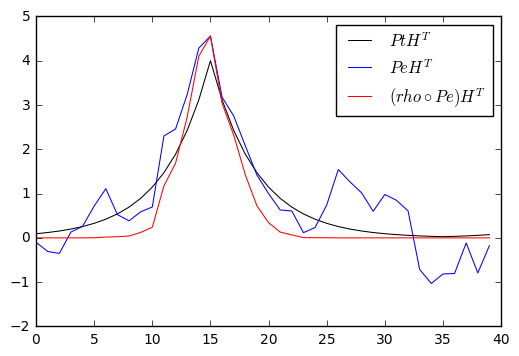

In [16]:
fig=plt.figure()
plt.plot(PtHobsT,label='$Pt H^T$',color='black',linestyle='solid',linewidth=0.75)
plt.plot(PeHobsT,label='$Pe H^T$',color='blue',linestyle='solid',linewidth=0.75)
plt.plot(PelocHobsT,label='$(rho \circ Pe) H^T$',color='red',linestyle='solid',linewidth=0.75,marker='',markersize=2)
plt.legend()

Localization rules out the noisy signal present in the original ${\bf P_e}{\bf H}^T$ vector. In the present case, $ (\rho \circ {\bf P_e}){\bf H}^T$ does not look like the original ${\bf P_t}{\bf H}^T$ in the tails. This is because subsampling prevents the ensemble from representing accurately the small covariances in the tails, and because the localization cutoff radius is smaller than the characteristic scale of the tails.

### 4.2. Localization with a tapering function

We turn to option 2: we define the appropriate tapering function with the Gaspari-Cohn function and the cutoff radius used for $\rho$ earlier.

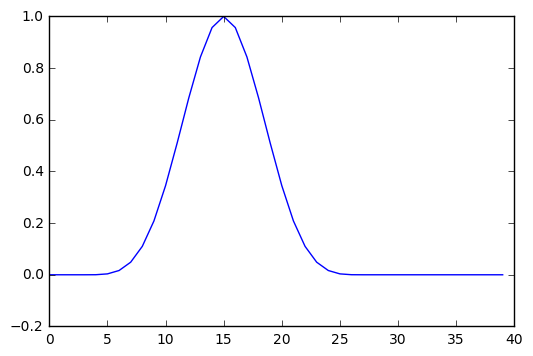

In [17]:
dist = np.abs(x_grid - x_grid[nobs])
dist = np.fmin(dist, L_grid - dist)
taper = gaspari_cohn(dist/crad)
plt.plot(taper)

The tapering function is applied to ${\bf P_e}{\bf H}^T$. Note it is (obviously) the same shape, i.e. a vector here because there is only one observation.

In [18]:
taperPeHobsT = taper * PeHobsT

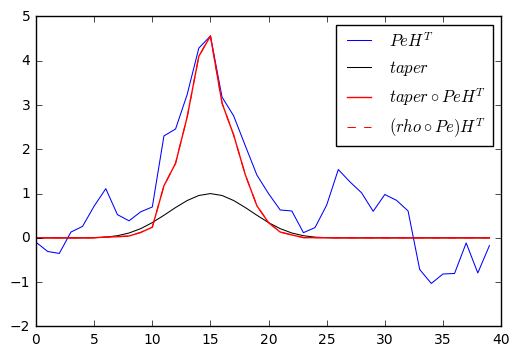

In [19]:
fig=plt.figure()
plt.plot(PeHobsT,label='$Pe H^T$',color='blue',linestyle='solid',linewidth=0.75)
plt.plot(taper,label='$taper$',color='black',linestyle='solid',linewidth=0.75)
plt.plot(taperPeHobsT,label='$taper \circ Pe H^T$',color='red',linestyle='solid',linewidth=1)
plt.plot(PelocHobsT,label='$(rho \circ Pe) H^T$',color='red',linestyle='dashed',linewidth=0.75,marker='',markersize=2)
plt.legend()

The result using the tapering function is exactly the same as using the localized covariance matrix.